# Comparison of Temperature Inversions between High Resolution Rapid Refresh (HRRR) Modelled Data and Observational Data

### Developed by Per Lundquist, M.S. Graduate Student, South Dakota Mines Atmospheric and Environmental Sciences

Building off the work from Vector_Method.ipynb, modelled sounding data from the HRRR Numerical Weather Prediction (NWP) model is ingested, inversion vectors are produced, and then comparison is made with observed sounding data.

Modelled sounding data is ingested using the Herbie python library, a tool developed by Dr. Brian Blaylock during his Ph.D work at the University of Utah, which is used to download recent and archived NWP GRIB2 data from the NOAA Open Data Dissemination (NODD) Program (formerly the Big Data Program). Observed data is ingested from the University of Wyoming's Atmospheric Soundings website using Siphon, a python tool developed by Unidata for querying data from various THREDDS servers

Inversion vectors are produced for both the modelled and observed data following Vector_Method.ipynb and then a method for determining whether the HRRR correctly produced an inversion is presented. Namely, this notebook will conclude that the HRRR correctly produced an inversion when a primary inversion vector is present in both the observed and modelled data *and* the height ranges of the modelled and observed primary inversion vector overlap with one another.

**Citation for Herbie**
Blaylock, B. K. (2022). Herbie: Retrieve Numerical Weather Prediction Model Data (Version 2022.9.0) [Computer software]. https://doi.org/10.5281/zenodo.4567540

## Imports

Before running through this notebook, be sure you have Herbie and any necessary custom libraries installed. In order to install Herbie, please install pip and run the following command in your python terminal:
`pip install herbie-data`

You can also install Herbie through an anaconda python environment:
`conda install -c conda-forge herbie-data`

For more details on installation and to retrieve source files [click here](https://github.com/blaylockbk/Herbie) to be brough to the Herbie GitHub page.

In order to run properly, Herbie needs the following custom libraries to be installed manually to your python environment:

| Library | Source | Link |
|----------|----------|----------|
| toolbox.gridded_data | Brian Blaylock's Carpenter Workshop | https://github.com/blaylockbk/Carpenter_Workshop |
| toolbox.cartopy_tools | Brian Blaylock's Carpenter Workshop | https://github.com/blaylockbk/Carpenter_Workshop |
| paint | Brian Blaylock's Carpenter Workshop | https://github.com/blaylockbk/Carpenter_Workshop |
| synoptic.services | Brian Blaylock's SynopticPy project | https://github.com/blaylockbk/SynopticPy |

These libraries can be downloaded and manually insterted into your local python environment. This environment for me was at the following local address: C: \ Users \ {username} \ .conda \ envs \ {envname} \ Lib \. However, this could be different on your system

**NOTE:** In order to use synoptic services, you will need an account from the [Synoptic Data Mesonet API website](https://synopticdata.com/). When running Herbie, you will be prompted to provide a token for Synoptic Data. To get the token that this program requests, go to My Account -> Data Credentials -> Create a Key AND Create a Token

In [1]:
#imports
from herbie import Herbie                               # main Herbie Module
from toolbox.gridded_data import pluck_points           # finds the nearest lat/lon point. Comes from Brian Blaylock's Carpenter Workshop project
from synoptic.services import stations_metadata         # Connects to Synoptic API. Comes from Blaylock's SynopticPy project

import math                                                  # A math library from the Standar Python Libraries
import numpy as np                                           # Numerical Python is a common number handling tool used in python
import pandas as pd                                          # A popular data analytics tool in python developed by Wes McKinney. Here it is used to handle array objects such as upper air soundings
pd.set_option('display.min_rows', 30)                        # Changing the default number of rows in a dataframe that pandas will display

from datetime import datetime                                # A module from the standard python library for handling date objects. Will be used to import data at specific times, but is also handy in iterating through dates
from siphon.simplewebservice.wyoming import WyomingUpperAir  # Siphon is a tool developed by Unidata for querying data from various THREDDS servers. This particular module accesses data from the THREDDS server owned by the University of Wyoming

import matplotlib.pyplot as plt                              # Matplotlib is a popular charting tool used in python. The pyplot module in particular creates images and charts
from toolbox.cartopy_tools import common_features            # includes a skew-T projection for matplotlib. Comes from Brian Blaylock's Carpenter Workshop project

## Import model data

Since downloading observed sounding data is rather simple and was showcased in Vector_Method.ipynb, let's take some time to learn how to grab HRRR model data using Herbie, as while it is a powerful tool, it can be rather convoluted.

First, let's create a Herbie object which will point to data on a server. It won't download the data, as doing so could fill up our RAM and cause the program to crash, but simply show what the dataset consists of

In [2]:
# set up the model run date. Must be a string and in the format YYYY-MM-DD HH:MM
date_of_interest = "2017-03-08 12:00"

# Create a Herbie object
H = Herbie(
    date_of_interest,  # model run date. Must be a string and in the format YYYY-MM-DD HH:MM
    model="hrrr",        # model name
    product="prs",       # model produce name (model dependent. TO GET MULTIPLE LAYERS, 'prs' IS RECOMMENDED)
    fxx=0,               # forecast lead time. We'll just use the analysis field of the HRRR for now
    save_dir='./Herbie/Data', # local file directory
                              # NOTE: Herbie doesn't like spaces in path names. MAKE SURE ALL DIRECTORIES DON'T
                              # HAVE SPACES IN THEIR NAMES!!!!!! Also, I've struggled to get this argument to work.
                              # Herbie will often just save data to C:/Users/{Username}/Data by default
    overwrite=True
)

# Location of GRIB file
print('GRIB file at: ', H.grib)

# Locatin of index file
print('index file at: ', H.idx)

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2017-Mar-08 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
GRIB file at:  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20170308/conus/hrrr.t12z.wrfprsf00.grib2
index file at:  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20170308/conus/hrrr.t12z.wrfprsf00.grib2.idx


Now let's see what's in the actual GRIB files. Herbie can read the GRIB .idx file (index file) and show us the file contents. Pay attention to the “search_this” column, as this will help you locate data you want to get when you actually start downloading it. 

Note: here we use `read_idx()` instead of Blaylock's `inventory()` module, which is what he uses in his tutorial page. This is because it no longer exists

In [3]:
# open the .idx file
H.read_idx()

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,794512,0-794512,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,50 mb,anl,:HGT:50 mb:anl
1,2,794512,1360494,794512-1360494,2017-03-08 12:00:00,2017-03-08 12:00:00,TMP,50 mb,anl,:TMP:50 mb:anl
2,3,1360494,1746844,1360494-1746844,2017-03-08 12:00:00,2017-03-08 12:00:00,RH,50 mb,anl,:RH:50 mb:anl
3,4,1746844,1747032,1746844-1747032,2017-03-08 12:00:00,2017-03-08 12:00:00,DPT,50 mb,anl,:DPT:50 mb:anl
4,5,1747032,2917112,1747032-2917112,2017-03-08 12:00:00,2017-03-08 12:00:00,SPFH,50 mb,anl,:SPFH:50 mb:anl
5,6,2917112,3360687,2917112-3360687,2017-03-08 12:00:00,2017-03-08 12:00:00,VVEL,50 mb,anl,:VVEL:50 mb:anl
6,7,3360687,3956212,3360687-3956212,2017-03-08 12:00:00,2017-03-08 12:00:00,UGRD,50 mb,anl,:UGRD:50 mb:anl
7,8,3956212,4521085,3956212-4521085,2017-03-08 12:00:00,2017-03-08 12:00:00,VGRD,50 mb,anl,:VGRD:50 mb:anl
8,9,4521085,5123658,4521085-5123658,2017-03-08 12:00:00,2017-03-08 12:00:00,ABSV,50 mb,anl,:ABSV:50 mb:anl
9,10,5123658,5123846,5123658-5123846,2017-03-08 12:00:00,2017-03-08 12:00:00,CLMR,50 mb,anl,:CLMR:50 mb:anl


To filter the data, we pass a regular expersion to the searchString argument to narrow down the data we are looking at.

In [4]:
# All fields that have "2-m above ground level" in their name
H.read_idx(searchString="HGT")

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,794512,0-794512,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,50 mb,anl,:HGT:50 mb:anl
14,15,5124869,5913755,5124869-5913755,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,75 mb,anl,:HGT:75 mb:anl
28,29,9930337,10724306,9930337-10724306,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,100 mb,anl,:HGT:100 mb:anl
42,43,14404534,15215490,14404534-15215490,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,125 mb,anl,:HGT:125 mb:anl
56,57,18710463,19517967,18710463-19517967,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,150 mb,anl,:HGT:150 mb:anl
70,71,23702597,24523004,23702597-24523004,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,175 mb,anl,:HGT:175 mb:anl
84,85,28963042,29783181,28963042-29783181,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,200 mb,anl,:HGT:200 mb:anl
98,99,34784269,35600202,34784269-35600202,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,225 mb,anl,:HGT:225 mb:anl
112,113,41037214,41846139,41037214-41846139,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,250 mb,anl,:HGT:250 mb:anl
126,127,46828074,47630474,46828074-47630474,2017-03-08 12:00:00,2017-03-08 12:00:00,HGT,275 mb,anl,:HGT:275 mb:anl


Now let's download the data we want. We'll do this using Herbie's built-in xarray module. Now, we could do this by writing `H.xarray()`, which will call the xarray module off of our already built herbie object, but in practice, it's easier to just create the herbie object and run it through xarray all in one go. 

Note the `product='prs'` which we used to build our initial Herbie object and grabs data using pressure coordinates. We grab this type of product, because the HRRR tends to have a lot of isobaric levels in its data rather than height levels

Also note that within the xarray module call, we just type "TMP" because this module expects a search string as its first argument. If we didn't include this, Herbie would download the entire GRIB dataset for this runtime, which can be extremely large and fill up the RAM, crashing the program

In [5]:
H_xf = Herbie(date_of_interest, model="HRRR", product="prs").xarray("TMP")
display(H_xf)

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2017-Mar-08 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.


[<xarray.Dataset>
 Dimensions:              (y: 1059, x: 1799)
 Coordinates:
     time                 datetime64[ns] 2017-03-08T12:00:00
     step                 timedelta64[ns] 00:00:00
     heightAboveGround    float64 2.0
     latitude             (y, x) float64 ...
     longitude            (y, x) float64 ...
     valid_time           datetime64[ns] ...
 Dimensions without coordinates: y, x
 Data variables:
     t2m                  (y, x) float32 ...
     gribfile_projection  object None
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP
     model:                   hrrr
     product:                 prs
     description:             High-Resolution Rapid Refresh - CONUS
     remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
  

Now, this may be difficult to read, but look close. We have 3 different datasets in here: a single grid showing temperature at 2m above ground level (AGL), 40 grids of temperature at different isobaric pressure levels, and a single grid showing temperature at the surface. These can be referenced as `H_xf[0]`, `H_xf[1]`, and `H_xf[2]`, and since we want a vertical profile, we'll use just `H_xf[1]`

It'd be easy enough to grab `H_xf[1]` every time we need a new date, but depending on the age of the data, this might not be the index where the data in isobaric pressure levels is located. Therefore, it'd be easier to make a function that locates which index we need

In [6]:
# dataframe is our xarray dataframe, in this case H_xf, and the key is the name of the data variable, in this case 't'
def key_err_fix(dataframe, key_):
    for i in range(len(dataframe)):

        coords_keys = list(dataframe[i].coords.keys())       # Check the coordinate system of H_xf[i]
        data_vars_keys = list(dataframe[i].data_vars.keys()) # Check the data variables of H_xf[i]
        
        # make sure that the coordinate system has isobaric pressure levels AND we have the variable requested available
        if any(ele in coords_keys for ele in ['isobaricInhPa']) and any(ele in data_vars_keys for ele in [key_]):
            return i
        
index_of_interest = key_err_fix(H_xf, 't')
print('Data will be grabbed from H_xf['+str(index_of_interest)+']')

Data will be grabbed from H_xf[1]


Our goal is to create a vertical profile of the atmosphere from the gridded data provided by Herbie. Therefore, we will need to figure out the location of the cell on the gridded data that is closest to the location we want the vertical profile, which in this example is the NWS office in Rapid City, SD (KUNR). Luckily, the `pluck_points` module from Blaylock's Carpenter Workshop toolbox is able to do this.

In order to get station information, we'll use the API from Synoptic Data. We'll do this using Blaylock's SynopticPy project, but remember, in order to use synoptic services, you will need an account from the Synoptic Data Mesonet API website. When this cell is run, you will be prompted to provide a token for Synoptic Data. To get the token that this program requests, go to My Account -> Data Credentials -> Create a Key AND Create a Token

In [7]:
# Get Point Data

closest_staions_array = stations_metadata(radius="KUNR,0") # Grab the station of interest location info. List of relavent function arguments: https://developers.synopticdata.com/mesonet/v2/station-selectors/
                                                           # KUNR is the 4-letter station code
                                                           # 0 is the search distance in miles for valid stations around KUNR
                                                           # This must be a string, not their own arguments. Silly, I know

station_points = np.array(list(zip(closest_staions_array.loc["longitude"], closest_staions_array.loc["latitude"])))

station_names = closest_staions_array.loc["STID"].to_numpy()  #### These are MesoWest stations, so we get a lot of them. ASOS, RAWS, you name it

# Test print
print(f"{len(station_names):,} stations to match to grid")
for i in range(len(station_names)):
    print(station_names[i], station_points[i])


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=KUNR,0&token=🙈HIDDEN

3 stations to match to grid
KUNR [-103.2108   44.0727]
COOPUNRS2 [-103.2108   44.0727]
G2100 [-103.21067   44.073  ]


It's nearly always the case that when attempting to match the station lat/lon to a grid point's lat/lon in the model, there will be slight inconsistencies. Blaylock struggled with this a lot, and it turned out, he couldn't use the .sel() funtion from xarray. Thus, he made his own function.

BIG NOTE: Blaylock has 2 functions that seemingly do the same thing: pluck_points and nearest_points. He claims the latter is faster, but when I attempt to use it, it gives me the wrong lat/lon every time. I always end up in China for some reason. Therefore, I don't mind using the clunky one

In [8]:
# Use Blaylock's pluck_points function to get nearest point in model to desired station
# This creates a vertical profile of whatever we grabbed
ds_pluck = pluck_points(H_xf[index_of_interest], station_points[:1], station_names[:1]) # return only one cell in each gridded layer
display(ds_pluck)

<xarray.Dataset>
Dimensions:              (isobaricInhPa: 40, point: 1)
Coordinates:
    time                 datetime64[ns] 2017-03-08T12:00:00
    step                 timedelta64[ns] 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 1.013e+03 1e+03 ... 75.0 50.0
    latitude             float64 44.08
    longitude            float64 -103.2
    valid_time           datetime64[ns] ...
    distance             (point) float64 1.554e+03
  * point                (point) object 'KUNR'
Data variables:
    t                    (point, isobaricInhPa) float32 276.2 275.5 ... 214.5
    gribfile_projection  (point) object None
Attributes: (12/14)
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    ...                      ...
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\perrl\data\hrrr\20170308\subset_ccef7c6...
    searchString:            TMP
    x_index:                 [746]
    y_index:                 [741]

Now we have our temperature data ready! Let's now quickly grab our dewpoints then plot a skew-T just like we did in Vector_Method.ipynb

In [9]:
H_xf = Herbie(date_of_interest, model="HRRR", product="prs").xarray("DPT")

index_of_interest = key_err_fix(H_xf, 'dpt')

ds_pluck_dpt = pluck_points(H_xf[index_of_interest], station_points[:1], station_names[:1])

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2017-Mar-08 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.


In [10]:
# Adjust data to °C
levels = len(ds_pluck.coords['isobaricInhPa']) # number of pressure levels we have

temp = np.empty(shape=levels)
dwpt = np.empty(shape=levels)
pres = np.empty(shape=levels)

for i in range(len(ds_pluck.coords['isobaricInhPa'])):
    temp[i] = (float(ds_pluck.data_vars['t'][0,i])-273.15) # adjusted from Kelvin to Celcius
    dwpt[i] = (float(ds_pluck_dpt.data_vars['dpt'][0,i])-273.15)
    pres[i] = (float(ds_pluck.coords['isobaricInhPa'][i]))

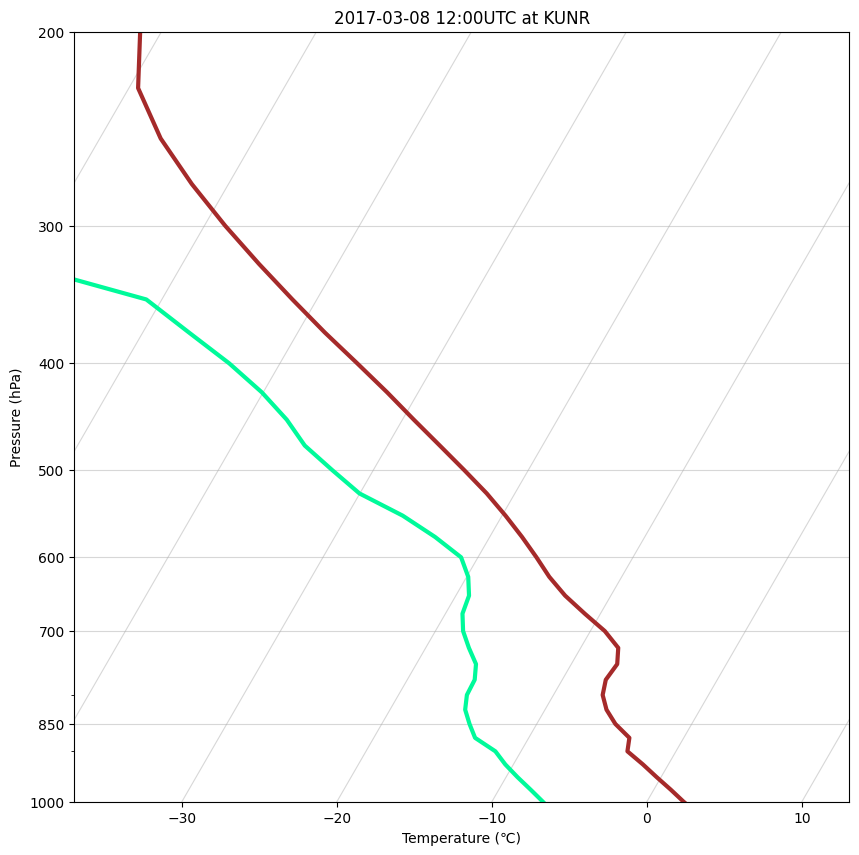

In [11]:
# plot a skew-T

# make a plot
# Change default to be better for skew-T
fig = plt.figure(figsize=(10, 10))

# set up plot
col_names = ['height', 'temperature', 'dewpoint'] # This line isn't crucial but it helps in labelling things

skew = plt.axes(projection='skewx', rotation=30)  # Takes the x-axis of the subplot and skews it by 30°. The skewx
                                                  # projection is part of Blaylock's toolbox (see imports). Since the 
                                                  # x axis is temperature/dewpoint in this scenario, we now have a 
                                                  # Skew-T plot! (now we just need that Log-P......)
        
                                                  # NOTE: We are labelling this plot 'skew' since it's a Skew-T in this
                                                  # scenario, but most often, you'll find people use 'ax' instead

        
# plot the data using logarithmic scale
# Since the y axix is pressure, we can use the .semilogy module to display it on a logarithmic scale
skew.semilogy(temp, pres, 'brown', linewidth=3, alpha=1)
skew.semilogy(dwpt, pres, 'mediumspringgreen', linewidth=3, alpha=1)



#### FORMATTING ####

# Set some better labels than the default
skew.set_title(date_of_interest + 'UTC at KUNR')
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Pressure (hPa)')

# Set the y-axis label format to display y-values exactly as they are written in the pandas dataframe
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)


# Now lets set the bounds of our chart to make it legible. I've noticed that sometimes NaN values will trickle
# into the data, making it difficult to determine where our temperature bounds are. In this case, we'll put the
# axis limits in a try and except block. If we can't determine the maximum temperature in the dataset due to bad data,
# we'll just use a default domain
try:
    skew.set_xlim(np.max(temp) - 40, np.max(temp) + 10.)
    skew.set_ylim(1000, 200)
except:
    skew.set_xlim(-10, 40)
    skew.set_ylim(1000, 200)


    
# These next two lines will make a predefined grid, setting tick marks at these exact values. This helps, especially on
# the temperature axis, as our skewed coordinate system makes it so we'd be missing some tick marks and the chart
# wouldn't look good. Comment out this code to see what I mean
skew.yaxis.set_major_locator(plt.FixedLocator([1000, 850, 700, 600, 500, 400, 300, 200]))

skew.xaxis.set_major_locator(plt.FixedLocator([-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40,
                                               -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]))

Before we go on, let's clean up our data a bit, saving it to a pandas dataframe since that will be easier to work with. We'll also want to adjust our heights to be in meters AGL rather than meters above sea level. To do this, the HRRR has a terrain, or orography, field. We'll simply subtract the orographic elevation at our site from the height at each level to get meters AGL

In [12]:
# function to grab the correct key for orography
def key_err_fix_orog(dataframe, key_):
    for i in range(len(dataframe)):

        coords_keys = list(dataframe[i].coords.keys())
        data_vars_keys = list(dataframe[i].data_vars.keys())

        if any(ele in data_vars_keys for ele in [key_]):
            return i

In [13]:
# get a new Herbie object using heights so we can get height information
H_xf = Herbie(date_of_interest, model="HRRR", product="prs").xarray("HGT")

# grab the HEIGHT data. In this case, geopotential height will suffice
index_of_interest = key_err_fix(H_xf, 'gh')
ds_pluck_gh = pluck_points(H_xf[index_of_interest], station_points[:1], station_names[:1])

# save the heights to a list
levels = len(ds_pluck_gh.coords['isobaricInhPa']) # number of pressure levels we have

height = np.empty(shape=levels)

for i in range(levels):
    height[i] = float(ds_pluck_gh.data_vars['gh'][0,i])

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2017-Mar-08 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [10] xarray.Datasets because cfgrib opened with multiple hypercubes.


In [14]:
# grab sfc data from orography
index_of_interest = key_err_fix_orog(H_xf, 'orog')
ds_pluck_orog = pluck_points(H_xf[index_of_interest], station_points[:1], station_names[:1])

sfc_height = float(ds_pluck_orog.data_vars['orog'])

# adjust all heights to AGL
height = [h - sfc_height for h in height]

In [15]:
# Complete the pandas dataframe
HRRR_df = pd.DataFrame({
    'Pressure level (hPa)': pres,
    'Height AGL (m)': height,
    'Temp (°C)': temp,
    'Dwpt (°C)': dwpt
})

display(HRRR_df)

,Pressure level (hPa),Height AGL (m),Temp (°C),Dwpt (°C)
0,1013.0,-909.697174,3.066980,-6.092261
1,1000.0,-827.915558,2.369806,-6.708411
2,975.0,-599.773438,1.086481,-7.954260
3,950.0,-391.610352,-0.278815,-9.257605
4,925.0,-178.991699,-1.643378,-10.523413
5,900.0,38.339294,-3.131567,-11.650214
6,875.0,261.176514,-3.508032,-13.462714
7,850.0,489.446899,-4.927405,-14.337714
8,825.0,723.408325,-6.032111,-15.150214
9,800.0,963.770996,-6.828436,-15.587714


## Ingest observational data and plot inversion vectors for comparison

Now that we have properly made a sounding using modelled data, let's use the methods from Vector_Method.ipynb to construct an inversion vector plot with both observed and modelled data in it. These next cells will be primarily from Vector_Method.ipynb, so if you need more information, refer to that notebook

Data for both will be cut off at 5km AGL

### Initialize data

In [16]:
# initialize the date and grab observed data
date = datetime(2017, 3, 8, 12) # year, month, day, hour

station = 'RAP'
OBS_df = WyomingUpperAir.request_data(date, station)

# only keep what we need:
OBS_df = pd.DataFrame({
        'pressure': OBS_df['pressure'],
        'height': OBS_df['height'],
        'temperature': OBS_df['temperature'],
        'dewpoint': OBS_df['dewpoint']
    })

# adjust to be in meters AGL
sfc_elev = OBS_df['height'].iloc[0]
OBS_df['height'] = [h - sfc_elev for h in OBS_df['height']]

In [17]:
# conduct a linear interpolation between points.

# ref_coord            = the desired location you want to conduct a linear interpolation. (y in the above equation)
# unfixed_data_coords  = array of the coordinate values in the raw data (contains y_above and y_below)
# unfixed_data_values  = array of the variable values from the raw data (contains x_above and x_below)
# increase_with_height = a boolean to tell the function if your height coordinate is increasing or decreasing with
#                        height. Used to switch between height and pressure coordinates
def linear_fix(ref_coord, unfixed_data_coords, unfixed_data_values, increase_with_height=False):
    
    # Rudimentary error checking. Doesn't stop the program, but won't create an interpolated dataframe
    if len(unfixed_data_coords) != len(unfixed_data_values):
        print('The variable and pressure arrays must be of equal length. Cancelling interpolation......')
        return
    
    # Height coordinates (function is the same in both scenarios)
    if increase_with_height:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] > ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (height_above - ref_height)) / (height_above - height_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # This won't run, but I put it here just in case. Perhaps I have anxiety, haha
    
    # Pressure coordinates
    else:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] < ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (pressure_above - ref_pressure)) / (pressure_above - pressure_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # just in case

Quick note about the HRRR data. If you scroll up and look at both the HRRR_df and associated Skew-T, you'll see that below 875mb, the height is in the ground, and the temperature and dewpoint plots are simply dragged linearly down from 875mb to mean sea level pressure. This is becauise the HRRR is making up data underground where there shouldn't be any. With that, we will need to determine which surface height is higher, the one on the HRRR or the one on the observed data, and cut off any data below that level

### Start data at same height

In [18]:
# Cut off data below the surface height
first_obs_height  = OBS_df['height'].iloc[0]
first_hrrr_height = HRRR_df['Height AGL (m)'].iloc[0]

# if the sfc value on the observed data is below the sfc on the hrrr, cut it off
if first_obs_height < first_hrrr_height:
    obs_sfc_data = pd.DataFrame({
        'pressure': [
            linear_fix(first_hrrr_height, OBS_df['height'], OBS_df['pressure'], increase_with_height=True)],
        'height': [first_hrrr_height],
        'temperature': [
            linear_fix(first_hrrr_height, OBS_df['height'], OBS_df['temperature'], increase_with_height=True)],
        'dewpoint': [
            linear_fix(first_hrrr_height, OBS_df['height'], OBS_df['dewpoint'], increase_with_height=True)]
    })
    
    # remove values below the first height in modelled data
    OBS_df = OBS_df[OBS_df['height'] >= first_hrrr_height]
    
    # add the new sfc data to it and sort
    OBS_df = pd.concat([obs_sfc_data, OBS_df])
    OBS_df = OBS_df.sort_values(by='height', ascending=True)
    OBS_df = OBS_df.reset_index(drop=True)
    
    
# if the sfc value on the hrrr is below the sfc on the observed data, cut it off
elif first_obs_height > first_hrrr_height:
    hrrr_sfc_data = pd.DataFrame({
        'Pressure level (hPa)': [
            linear_fix(first_obs_height, HRRR_df['Height AGL (m)'], HRRR_df['Pressure level (hPa)'],
                       increase_with_height=True)],
        'Height AGL (m)': [first_obs_height],
        'Temp (°C)': [linear_fix(first_obs_height, HRRR_df['Height AGL (m)'], HRRR_df['Temp (°C)'],
                                 increase_with_height=True)],
        'Dwpt (°C)': [linear_fix(first_obs_height, HRRR_df['Height AGL (m)'], HRRR_df['Dwpt (°C)'],
                                 increase_with_height=True)]
    })
    
    # remove values below the first height in observed data
    HRRR_df = HRRR_df[HRRR_df['Height AGL (m)'] >= first_obs_height]
    
    # add the new sfc data to it and sort
    HRRR_df = pd.concat([hrrr_sfc_data, HRRR_df])
    HRRR_df = HRRR_df.sort_values(by='Height AGL (m)', ascending=True)
    HRRR_df = HRRR_df.reset_index(drop=True)
    
display(OBS_df)
display(HRRR_df)

,pressure,height,temperature,dewpoint
0,899.0,0,-4.5,-10.5
1,895.0,35,-3.1,-12.1
2,883.0,143,-2.9,-13.9
3,877.7,190,-3.2,-14.4
4,851.0,435,-4.9,-16.9
5,850.0,444,-4.9,-16.9
6,812.2,800,-7.5,-15.8
7,810.0,821,-7.7,-15.7
8,791.0,1006,-5.3,-16.3
9,781.1,1105,-5.8,-16.3


,Pressure level (hPa),Height AGL (m),Temp (°C),Dwpt (°C)
0,904.410242,0.000000,-2.869036,-11.451435
1,900.000000,38.339294,-3.131567,-11.650214
2,875.000000,261.176514,-3.508032,-13.462714
3,850.000000,489.446899,-4.927405,-14.337714
4,825.000000,723.408325,-6.032111,-15.150214
5,800.000000,963.770996,-6.828436,-15.587714
6,775.000000,1211.194458,-7.192877,-15.650214
7,750.000000,1466.665405,-7.039221,-16.150214
8,725.000000,1730.768433,-7.577368,-17.212714
9,700.000000,2003.121216,-9.068762,-18.212714


### Change dataframes to standard height coordinate system

In [19]:
# Make a new dataframe for the OBSERVED data such that datapoints are every 100m
standard_heights = np.arange(0, 5000, 100)

# Make arrays for each variable we care about and conduct linear interpolation    
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, OBS_df['height'], OBS_df['pressure'], increase_with_height=True))
    temps.append(linear_fix(h, OBS_df['height'], OBS_df['temperature'], increase_with_height=True))
    dwpts.append(linear_fix(h, OBS_df['height'], OBS_df['dewpoint'], increase_with_height=True))
    
OBS_df_standard = pd.DataFrame({
    'pressure': pressures,
    'height': standard_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

In [20]:
# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
OBS_df_standard['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value
for i in range(len(OBS_df_standard['temperature'])):
    
    if i == ( len(OBS_df_standard['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        OBS_df_standard['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
    else:
        OBS_df_standard['lapse_rate'].iloc[i] = (OBS_df_standard['temperature'].iloc[i+1] - OBS_df_standard['temperature'].iloc[i]) / (OBS_df_standard['height'].iloc[i+1] - OBS_df_standard['height'].iloc[i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\600026302.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OBS_df_standard['lapse_rate'].iloc[i] = (OBS_df_standard['temperature'].iloc[i+1] - OBS_df_standard['temperature'].iloc[i]) / (OBS_df_standard['height'].iloc[i+1] - OBS_df_standard['height'].iloc[i])


In [21]:
# Do the same to the HRRR data
pressures = []
temps     = []
dwpts     = []

for h in standard_heights:
    pressures.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Pressure level (hPa)'], increase_with_height=True))
    temps.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Temp (°C)'], increase_with_height=True))
    dwpts.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Dwpt (°C)'], increase_with_height=True))
    
HRRR_df_standard = pd.DataFrame({
    'Pressure level (hPa)': pressures,
    'Height AGL (m)': standard_heights,
    'Temp (°C)': temps,
    'Dwpt (°C)': dwpts
})

# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
HRRR_df_standard['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value
for i in range(len(HRRR_df_standard['Temp (°C)'])):
    
    if i == ( len(HRRR_df_standard['Temp (°C)']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        HRRR_df_standard['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
    else:
        HRRR_df_standard['lapse_rate'].iloc[i] = (HRRR_df_standard['Temp (°C)'].iloc[i+1] - HRRR_df_standard['Temp (°C)'].iloc[i]) / (HRRR_df_standard['Height AGL (m)'].iloc[i+1] - HRRR_df_standard['Height AGL (m)'].iloc[i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\2299148327.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRRR_df_standard['lapse_rate'].iloc[i] = (HRRR_df_standard['Temp (°C)'].iloc[i+1] - HRRR_df_standard['Temp (°C)'].iloc[i]) / (HRRR_df_standard['Height AGL (m)'].iloc[i+1] - HRRR_df_standard['Height AGL (m)'].iloc[i])


### Get inversions

In [22]:
# Follow Vector_Method.ipynb to create a plot with both observed and modelled inversion vectors on it
# We'll just use a list to save the inversions
OBS_inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(OBS_df_standard['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( OBS_df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [OBS_df_standard['height'][i], OBS_df_standard['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( OBS_df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [OBS_df_standard['height'][i], OBS_df_standard['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        OBS_inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0
        
        
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in OBS_inversions:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
OBS_inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
OBS_inversion_ranks = OBS_inversion_ranks.sort_values(by='Distance', ascending=False)
OBS_inversion_ranks = OBS_inversion_ranks.reset_index(drop=True)

display(OBS_inversion_ranks)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,200.011259,800,-7.500000,1000,-5.377838
1,200.000159,1200,-6.265686,1400,-6.013366
2,100.011557,0,-4.500000,100,-2.979630
3,100.002500,3100,-17.900000,3200,-17.192958


In [23]:
# And the same for the HRRR
HRRR_inversions = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(HRRR_df_standard['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( HRRR_df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [HRRR_df_standard['Height AGL (m)'][i], HRRR_df_standard['Temp (°C)'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( HRRR_df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [HRRR_df_standard['Height AGL (m)'][i], HRRR_df_standard['Temp (°C)'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        HRRR_inversions.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0
        
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in HRRR_inversions:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
HRRR_inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
HRRR_inversion_ranks = HRRR_inversion_ranks.sort_values(by='Distance', ascending=False)
HRRR_inversion_ranks = HRRR_inversion_ranks.reset_index(drop=True)

display(HRRR_inversion_ranks)

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,200.000024,1200,-7.176388,1400,-7.079318


### Normalize the coordinate system to get the primary inversion

In [24]:
# take the values in standard_heights and OBS_df_standard and normalize to the specified range
# Heights will be nomalized from a range of [0, 5000] to [0, 1]
# Temperatures will be normalized from a range of [-39, 40] to [0, 1]

normalized_heights = np.arange(0, 1.0, (100/5000.)) # (start value, end value, increment)

temps = np.zeros(shape=len(normalized_heights))
dwpts = np.zeros(shape=len(normalized_heights))

for i in range(len(normalized_heights)):

    # adding 39 puts it to a range of [0, 79], then simply divide by 79 to get [0, 1]
    if OBS_df_standard['temperature'][i] is not None:
        temps[i] = (OBS_df_standard['temperature'][i] + 39.) / (39.+40.)
    if OBS_df_standard['dewpoint'][i] is not None:
        dwpts[i] = (OBS_df_standard['dewpoint'][i] + 39.) / (39.+40.)
        
OBS_df_normalized = pd.DataFrame({
    'pressure': OBS_df_standard['pressure'][i],
    'height': normalized_heights,
    'temperature': temps,
    'dewpoint': dwpts
})

# set up all the lapse rates through finite differencing

# initialize a new lapse rate column that is full of zeros
OBS_df_normalized['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value
for i in range(len(OBS_df_normalized['temperature'])):
    
    if i == ( len(OBS_df_normalized['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        OBS_df_normalized['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
    else:
        OBS_df_normalized['lapse_rate'].iloc[i] = (OBS_df_normalized['temperature'].iloc[i+1] - OBS_df_normalized['temperature'].iloc[i]) / (OBS_df_normalized['height'].iloc[i+1] - OBS_df_normalized['height'].iloc[i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\3200760069.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OBS_df_normalized['lapse_rate'].iloc[i] = (OBS_df_normalized['temperature'].iloc[i+1] - OBS_df_normalized['temperature'].iloc[i]) / (OBS_df_normalized['height'].iloc[i+1] - OBS_df_normalized['height'].iloc[i])


In [25]:
# Likewise with HRRR data

temps = np.zeros(shape=len(normalized_heights))
dwpts = np.zeros(shape=len(normalized_heights))

for i in range(len(normalized_heights)):

    # adding 39 puts it to a range of [0, 79], then simply divide by 79 to get [0, 1]
    if HRRR_df_standard['Temp (°C)'][i] is not None:
        temps[i] = (HRRR_df_standard['Temp (°C)'][i] + 39.) / (39.+40.)
    if HRRR_df_standard['Dwpt (°C)'][i] is not None:
        dwpts[i] = (HRRR_df_standard['Dwpt (°C)'][i] + 39.) / (39.+40.)
        
HRRR_df_normalized = pd.DataFrame({
    'Pressure level (hPa)': HRRR_df_standard['Pressure level (hPa)'][i],
    'Height AGL (m)': normalized_heights,
    'Temp (°C)': temps,
    'Dwpt (°C)': dwpts
})

# initialize a new lapse rate column that is full of zeros
HRRR_df_normalized['lapse_rate'] = 0

# loop through every point in the dataframe, assigning a lapse rate value
for i in range(len(HRRR_df_normalized['Temp (°C)'])):
    
    if i == ( len(HRRR_df_normalized['Temp (°C)']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
        HRRR_df_normalized['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
    else:
        HRRR_df_normalized['lapse_rate'].iloc[i] = (HRRR_df_normalized['Temp (°C)'].iloc[i+1] - HRRR_df_normalized['Temp (°C)'].iloc[i]) / (HRRR_df_normalized['Height AGL (m)'].iloc[i+1] - HRRR_df_normalized['Height AGL (m)'].iloc[i])

C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\1927828108.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRRR_df_normalized['lapse_rate'].iloc[i] = (HRRR_df_normalized['Temp (°C)'].iloc[i+1] - HRRR_df_normalized['Temp (°C)'].iloc[i]) / (HRRR_df_normalized['Height AGL (m)'].iloc[i+1] - HRRR_df_normalized['Height AGL (m)'].iloc[i])


In [26]:
OBS_inversions_norm = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(OBS_df_normalized['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( OBS_df_normalized['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [OBS_df_normalized['height'][i], OBS_df_normalized['temperature'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( OBS_df_normalized['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [OBS_df_normalized['height'][i], OBS_df_normalized['temperature'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        OBS_inversions_norm.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0
        

In [27]:
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in OBS_inversions_norm:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
OBS_inversion_ranks_norm = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])

OBS_inversion_ranks      = OBS_inversion_ranks.sort_values(by='Starting Height', ascending=False)
OBS_inversion_ranks_norm = OBS_inversion_ranks_norm.sort_values(by='Starting Height', ascending=False)
OBS_inversion_ranks      = OBS_inversion_ranks.reset_index(drop=True)
OBS_inversion_ranks_norm = OBS_inversion_ranks_norm.reset_index(drop=True)

OBS_inversion_ranks['Distance'] = OBS_inversion_ranks_norm['Distance']

OBS_inversion_ranks = OBS_inversion_ranks.sort_values(by='Distance', ascending=False)
OBS_inversion_ranks = OBS_inversion_ranks.reset_index(drop=True)
display(OBS_inversion_ranks) 

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,0.048183,800,-7.500000,1000,-5.377838
1,0.040127,1200,-6.265686,1400,-6.013366
2,0.027756,0,-4.500000,100,-2.979630
3,0.021911,3100,-17.900000,3200,-17.192958


In [28]:
# Likewise with the HRRR data
HRRR_inversions_norm = []

# booleans to check if we started/finished grabbing an inversion
start_grabbed = 0
end_grabbed = 0

# Scan all points to find positive lapse rates
for i in range(len(HRRR_df_normalized['lapse_rate'])):
    
    # Positive lapse rate found! Save this coordiate as [height, temp]
    if ( HRRR_df_normalized['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
        start_coord = [HRRR_df_normalized['Height AGL (m)'][i], HRRR_df_normalized['Temp (°C)'][i]]
        start_grabbed = 1 # we just grabbed the start point, so tell the program we did
        end_grabbed = 0   # haven't grabbed the ending point though...
    
    # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
    # Note, this part can only run if we've already started grabbing an inversion
    elif ( HRRR_df_normalized['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
        end_coord = [HRRR_df_normalized['Height AGL (m)'][i], HRRR_df_normalized['Temp (°C)'][i]]
        start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
        end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it
    
    # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
    if end_grabbed == 1 and start_grabbed == 0:
        HRRR_inversions_norm.append([start_coord, end_coord])
        start_grabbed = 0
        end_grabbed = 0
        

In [29]:
# Likewise with the HRRR data
# Calculate distances and store them with their respective line segments
data = [] # simple list to store the data of each inversion. Not organized quite yet

for line in HRRR_inversions_norm:
    point1, point2 = line
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

    # Extract relevant information
    start_height = point1[0]
    start_temp = point1[1]
    end_height = point2[0]
    end_temp = point2[1]
    
    # Save the data to the list
    data.append([distance, start_height, start_temp, end_height, end_temp])


# clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
HRRR_inversion_ranks_norm = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])

HRRR_inversion_ranks      = HRRR_inversion_ranks.sort_values(by='Starting Height', ascending=False)
HRRR_inversion_ranks_norm = HRRR_inversion_ranks_norm.sort_values(by='Starting Height', ascending=False)
HRRR_inversion_ranks      = HRRR_inversion_ranks.reset_index(drop=True)
HRRR_inversion_ranks_norm = HRRR_inversion_ranks_norm.reset_index(drop=True)

HRRR_inversion_ranks['Distance'] = HRRR_inversion_ranks_norm['Distance']

HRRR_inversion_ranks = HRRR_inversion_ranks.sort_values(by='Distance', ascending=False)
HRRR_inversion_ranks = HRRR_inversion_ranks.reset_index(drop=True)
display(HRRR_inversion_ranks) 

,Distance,Starting Height,Starting Temperature,Ending Height,Ending Temperature
0,0.040019,1200,-7.176388,1400,-7.079318


In [30]:
OBS_prime  = OBS_inversion_ranks.head(1)
HRRR_prime = HRRR_inversion_ranks.head(1)

### Plot the inversion vectors

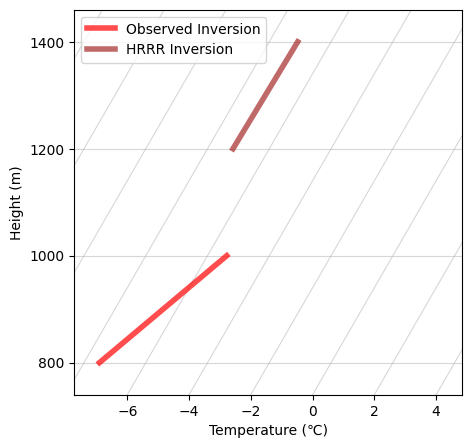

In [31]:
# Plot the primary inversions

fig = plt.figure(figsize=(5, 5)) # please excuse the figure size. It's small to look good on my poster

# set up plot
col_names = ['height', 'temperature', 'dewpoint']
skew = plt.axes(projection='skewx', rotation=30)
   
#plot the inversions
    
OBS_x_values  = [OBS_prime['Starting Temperature'].iloc[0], OBS_prime['Ending Temperature'].iloc[0]]
OBS_y_values  = [OBS_prime['Starting Height'].iloc[0], OBS_prime['Ending Height'].iloc[0]]
HRRR_x_values = [HRRR_prime['Starting Temperature'].iloc[0], HRRR_prime['Ending Temperature'].iloc[0]]
HRRR_y_values = [HRRR_prime['Starting Height'].iloc[0], HRRR_prime['Ending Height'].iloc[0]]

# Plot the line segment
skew.plot(OBS_x_values, OBS_y_values, 'r', linewidth=4, alpha=0.7)
skew.plot(HRRR_x_values, HRRR_y_values, 'brown', linewidth=4, alpha=0.7) 


# Set some better labels than the default
# skew.set_title(date_of_interest + 'UTC KUNR')
skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.set_ylabel('Height (m)')
plt.legend(['Observed Inversion', 'HRRR Inversion'])

# Set the y-axis label format to display y-values exactly as written
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
plt.grid(alpha=0.5)

# play with the bounds
x_min = np.min([np.min(OBS_x_values), np.min(HRRR_x_values)])
y_min = np.min([np.min(OBS_y_values), np.min(HRRR_y_values)])
x_max = np.max([np.max(OBS_x_values), np.max(HRRR_x_values)])
y_max = np.max([np.max(OBS_y_values), np.max(HRRR_y_values)])

x_expand = (x_max - x_min) * 0.1
y_expand = (y_max - y_min) * 0.1

plt.xlim(x_min - x_expand, x_max + x_expand + 10) # adding an integer compensates for the skewed coordinates
plt.ylim(y_min - y_expand, y_max + y_expand)


#     set tick marks
skew.yaxis.set_major_locator(plt.FixedLocator([-200, 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]))
skew.xaxis.set_major_locator(plt.FixedLocator([-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,
                                               12, 14, 16, 18, 20, 22, 24, 26, 28, 30]))
plt.show()

Awesome! Now we have the primary inversion for both observed and modelled data and can check if the HRRR correctly produced the presence of a temperature inversion. Unfortunately, in this case, while the HRRR did predict a temperature inversion, it is not at the same location as the one we have in the observed data. For that reason, we have to conclude that the HRRR inaccurately produced the presence of an inversion where none exists, i.e. a False Positive

Let's set up some criteria for when we can conclude that the HRRR correctly produced an inversion

-----------------------------------

## Criteria for concluding the HRRR correctly produced an inversion

We will conclude that the HRRR correctly predicted an inversion when

* There is an inversion vector for both observed and modelled data AND
* The height domains of the observed and modelled inversion vector overlap

Essentially this just means that the HRRR must produce an inversion when one should exist and that inversion should be at the same location as the actual temperature inversion. Let's now find a date where both these criteria are met. While we're at it, let's also turn our code above into user defined functions to make our lives easier

In [32]:
#########################################################
### THE LINEAR INTERPOLATION FUNCTION USED EVERYWHERE ###
#########################################################

# conduct a linear interpolation between points.

# ref_coord            = the desired location you want to conduct a linear interpolation. (y in the above equation)
# unfixed_data_coords  = array of the coordinate values in the raw data (contains y_above and y_below)
# unfixed_data_values  = array of the variable values from the raw data (contains x_above and x_below)
# increase_with_height = a boolean to tell the function if your height coordinate is increasing or decreasing with
#                        height. Used to switch between height and pressure coordinates
def linear_fix(ref_coord, unfixed_data_coords, unfixed_data_values, increase_with_height=False):
    
    # Rudimentary error checking. Doesn't stop the program, but won't create an interpolated dataframe
    if len(unfixed_data_coords) != len(unfixed_data_values):
        print('The variable and pressure arrays must be of equal length. Cancelling interpolation......')
        return
    
    # Height coordinates (function is the same in both scenarios)
    if increase_with_height:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] > ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (height_above - ref_height)) / (height_above - height_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # This won't run, but I put it here just in case. Perhaps I have anxiety, haha
    
    # Pressure coordinates
    else:
        
        # scan the data until we find the first point above our reference point
        for i in range(len(unfixed_data_values)):
            if unfixed_data_coords[i] < ref_coord:
                # interpolate temp and rh between pressure levels above/below surface pressure to get surface values
                #
                # Equation: x = x_above + ( ((x_below - x_above) * (pressure_above - ref_pressure)) / (pressure_above - pressure_below) )

                fixed_value = unfixed_data_values[i] + (((unfixed_data_values[i - 1] - unfixed_data_values[i]) * (
                            unfixed_data_coords[i] - ref_coord)) / (unfixed_data_coords[i] - unfixed_data_coords[
                    i - 1]))
                return fixed_value
                break  # just in case

In [33]:
#########################################
### GRABBING THE HRRR DATA VIA HERBIE ###
#########################################

# A revised key_err_fix() function that should grab the index for the xarray dataframe we want from Herbie, regardless
# of the coordinate system
def key_err_fix(dataframe, key_, orog_check=0):
    
    for i in range(len(dataframe)):
        
        coords_keys    = list(dataframe[i].coords.keys())
        data_vars_keys = list(dataframe[i].data_vars.keys())
        
        if orog_check == 1:
            if any(ele in data_vars_keys for ele in [key_]):
                return i
        else:
            if any(ele in coords_keys for ele in ['isobaricInhPa']) and any(ele in data_vars_keys for ele in [key_]):
                return i
            
            
# A function for grabbing Herbie data depending on the variable we want
# run_time = the date of interest
# var      = the requested data variable, in this case temperature or orography
# stid     = the Herbie compatible station identifier. Typically, it's different than the one used in siphon
# model_   = the NWP model to be used
# product_ = the type of product coordinates to be used
def get_HRRR_data(run_time, var, stid, model_='HRRR', product_='prs'):
   
    print('\nGrabbing HRRR '+var+' data for '+run_time)
    
    # A lookup table with the appropriate data variable key from the xarray dataframe needed
    match var:
        case "TMP":
            key_ = 't'
        case "DPT":
            key_ = 'dpt'
        case "U":
            key_ = 'u'
        case "V":
            key_ = 'v'
        case "W":
            var = "V"
            key_ = 'w'
        case "RH":
            key_ = 'r'
        case "HGT":
            key_ = 'gh'
        case "OROG":
            var = "HGT"
            key_ = 'orog'
    
    # Get HRRR dataframe
    try:
        # make initial Herbie object
        H_xf = Herbie(run_time, model=model_, product=product_, verbose=False).xarray(var)
        
        # in order to use key_err_fix, the Herbie object must be a list of xarray dataframes. If there's only one
        # dataframe, Herbie won't put it in a list, so we'll fix that here
        if isinstance(H_xf, list):
            pass
        else:
            H_xf =[H_xf]
            
    except Exception as e:
        print('time ' + run_time + ' could not be collected. Omitting from records............\n')
        
        return 'nan','nan','nan'
    
    # set lookup index
    if key_ == 'orog':
        index_ = key_err_fix(H_xf, key_, orog_check=1)
    else:
        index_ = key_err_fix(H_xf, key_)
    
    try:
        
        # Get Point Data
        closest_staions_array = stations_metadata(radius=stid+",0",verbose=False) 
        station_points = np.array(list(zip(closest_staions_array.loc["longitude"], closest_staions_array.loc["latitude"])))
        station_names = closest_staions_array.loc["STID"].to_numpy()

        # make secondary xarray object with vertical profile of the variable we want a the location we want
        ds_pluck = pluck_points(H_xf[index_], station_points[:1], station_names[:1],verbose=False) # see lookup table in above cell
        
        # confirm we have the coordinate system we want
        if any(coord_name == 'isobaricInhPa' for coord_name in ds_pluck.coords):
        
            # number of levels to work with
            levels = len(ds_pluck.coords['isobaricInhPa'])

            # save data to lists. IT'S IMPORTANT THAT THEY'RE LISTS NOT NUMPY ARRAYS YET!!!
            var_out = []
            pres = []

            for i in range(levels):
                var_out.append(float(ds_pluck.data_vars[key_][0,i])) # see lookup table above
                pres.append(float(ds_pluck.coords['isobaricInhPa'][i]))


            # return the variables
            return var_out, pres, levels
        
        # just return one variable if different coords
        else:
            
            return float(ds_pluck.data_vars[key_])
        
    
    except Exception as e:
        print('time ' + run_time + ' could not be collected. Omitting from records............\n')
        
        return 'nan','nan','nan'
    

# Grab a raw modelled profile
def mk_HRRR_df(curr_date):
    
    # get HRRR data
    height_HRRR, pres_HRRR, levels_HRRR = get_HRRR_data(curr_date, 'HGT', 'KUNR')
    temp_HRRR, pres_HRRR, levels_HRRR = get_HRRR_data(curr_date, 'TMP', 'KUNR')
    dwpt_HRRR, pres_HRRR, levels_HRRR = get_HRRR_data(curr_date, 'DPT', 'KUNR')
    
    # surface elev (labeled Geopotential Height - Orography in the file)
    sfc_elev = get_HRRR_data(curr_date, 'OROG', 'KUNR')
    
    # adjust temps because they're in K
    # adjust height because it's in units of meters above msl
    temp_HRRR = [temp - 273.15 for temp in temp_HRRR]
    dwpt_HRRR = [dwpt - 273.15 for dwpt in dwpt_HRRR]

    height_HRRR = [height - sfc_elev for height in height_HRRR]
    
    # put it all in a dataframe
    HRRR_df = pd.DataFrame({
        'Pressure level (hPa)': pres_HRRR,
        'Height AGL (m)': height_HRRR,
        'Temp (°C)': temp_HRRR,
        'Dwpt (°C)': dwpt_HRRR
    })
    
    return HRRR_df

In [34]:
#############################################
### GRABBING THE OBSERVED DATA VIA SIPHON ###
#############################################
def get_OBS_data(run_time, stid):
    
    print('\nGrabbing OBS data for '+run_time)
    try:
        #Provide date/time: year, month, day, hour
        date = datetime.strptime(run_time, "%Y-%m-%d %H:%M")
        #Provide station (note, this database lists the Rapid City sounding site as RAP rather than UNR)
        station = stid

        #And download the data
        df = WyomingUpperAir.request_data(date, station)
        
        # adjust to be in meters AGL
        sfc_elev = df['height'].iloc[0]
        df['height'] = [h - sfc_elev for h in df['height']]

        #Define some variables to make things easy
        p= df['pressure'].values
        h= df['height'].values
        t= df['temperature'].values
        td= df['dewpoint'].values
        u= df['u_wind'].values
        v= df['v_wind'].values
        
        better_df = pd.DataFrame({
            'pressure': p,
            'height': h,
            'temperature': t,
            'dewpoint': td
        })
        
        return better_df
        
    except Exception as e:
        print('time ' + run_time + ' could not be collected. Omitting from records............\n')
        
        return 'nan'


In [35]:
########################################################
### SLICE THE DATAFRAMES TO START AT THE SAME HEIGHT ###
########################################################
def start_at_same_height(OBS_df, HRRR_df):
    
    new_OBS_df  = OBS_df
    new_HRRR_df = HRRR_df
    
    first_obs_height  = new_OBS_df['height'].iloc[0]
    first_hrrr_height = new_HRRR_df['Height AGL (m)'].iloc[0]

    # if the sfc value on the observed data is below the sfc on the hrrr, cut it off
    if first_obs_height < first_hrrr_height:
        obs_sfc_data = pd.DataFrame({
            'pressure': [
                linear_fix(first_hrrr_height, new_OBS_df['height'], new_OBS_df['pressure'], increase_with_height=True)],
            'height': [first_hrrr_height],
            'temperature': [
                linear_fix(first_hrrr_height, new_OBS_df['height'], new_OBS_df['temperature'], increase_with_height=True)],
            'dewpoint': [
                linear_fix(first_hrrr_height, new_OBS_df['height'], new_OBS_df['dewpoint'], increase_with_height=True)]
        })

        # remove values below the first height in modelled data
        new_OBS_df = new_OBS_df[new_OBS_df['height'] >= first_hrrr_height]

        # add the new sfc data to it and sort
        new_OBS_df = pd.concat([obs_sfc_data, new_OBS_df])
        new_OBS_df = OBS_df.sort_values(by='height', ascending=True)
        new_OBS_df = OBS_df.reset_index(drop=True)


    # if the sfc value on the hrrr is below the sfc on the observed data, cut it off
    elif first_obs_height > first_hrrr_height:
        hrrr_sfc_data = pd.DataFrame({
            'Pressure level (hPa)': [
                linear_fix(first_obs_height, new_HRRR_df['Height AGL (m)'], new_HRRR_df['Pressure level (hPa)'],
                           increase_with_height=True)],
            'Height AGL (m)': [first_obs_height],
            'Temp (°C)': [linear_fix(first_obs_height, new_HRRR_df['Height AGL (m)'], new_HRRR_df['Temp (°C)'],
                                     increase_with_height=True)],
            'Dwpt (°C)': [linear_fix(first_obs_height, new_HRRR_df['Height AGL (m)'], new_HRRR_df['Dwpt (°C)'],
                                     increase_with_height=True)]
        })

        # remove values below the first height in observed data
        new_HRRR_df = HRRR_df[new_HRRR_df['Height AGL (m)'] >= first_obs_height]

        # add the new sfc data to it and sort
        new_HRRR_df = pd.concat([hrrr_sfc_data, new_HRRR_df])
        HRRR_df = HRRR_df.sort_values(by='Height AGL (m)', ascending=True)
        HRRR_df = HRRR_df.reset_index(drop=True)
        
    return new_OBS_df, new_HRRR_df

In [36]:
#############################################################
### CONVERT THE DATAFRAME TO A STANDARD HEIGHT COORDINATE ###
#############################################################
def mk_height_df(OBS_df, HRRR_df):
    
    # Make a new dataframe for the OBSERVED data such that datapoints are every 100m
    standard_heights = np.arange(0, 5000, 100)

    # Make arrays for each variable we care about and conduct linear interpolation    
    pressures = []
    temps     = []
    dwpts     = []

    for h in standard_heights:
        pressures.append(linear_fix(h, OBS_df['height'], OBS_df['pressure'], increase_with_height=True))
        temps.append(linear_fix(h, OBS_df['height'], OBS_df['temperature'], increase_with_height=True))
        dwpts.append(linear_fix(h, OBS_df['height'], OBS_df['dewpoint'], increase_with_height=True))

    OBS_df_standard = pd.DataFrame({
        'pressure': pressures,
        'height': standard_heights,
        'temperature': temps,
        'dewpoint': dwpts
    })
    
    # set up all the lapse rates through finite differencing

    # initialize a new lapse rate column that is full of zeros
    OBS_df_standard['lapse_rate'] = 0

    # loop through every point in the dataframe, assigning a lapse rate value
    for i in range(len(OBS_df_standard['temperature'])):

        if i == ( len(OBS_df_standard['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
            OBS_df_standard['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
        else:
            OBS_df_standard['lapse_rate'].iloc[i] = (OBS_df_standard['temperature'].iloc[i+1] - OBS_df_standard['temperature'].iloc[i]) / (OBS_df_standard['height'].iloc[i+1] - OBS_df_standard['height'].iloc[i])
    
    # Do the same to the HRRR data
    pressures = []
    temps     = []
    dwpts     = []

    for h in standard_heights:
        pressures.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Pressure level (hPa)'], increase_with_height=True))
        temps.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Temp (°C)'], increase_with_height=True))
        dwpts.append(linear_fix(h, HRRR_df['Height AGL (m)'], HRRR_df['Dwpt (°C)'], increase_with_height=True))

    HRRR_df_standard = pd.DataFrame({
        'Pressure level (hPa)': pressures,
        'Height AGL (m)': standard_heights,
        'Temp (°C)': temps,
        'Dwpt (°C)': dwpts
    })

    # set up all the lapse rates through finite differencing

    # initialize a new lapse rate column that is full of zeros
    HRRR_df_standard['lapse_rate'] = 0

    # loop through every point in the dataframe, assigning a lapse rate value
    for i in range(len(HRRR_df_standard['Temp (°C)'])):

        if i == ( len(HRRR_df_standard['Temp (°C)']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
            HRRR_df_standard['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
        else:
            HRRR_df_standard['lapse_rate'].iloc[i] = (HRRR_df_standard['Temp (°C)'].iloc[i+1] - HRRR_df_standard['Temp (°C)'].iloc[i]) / (HRRR_df_standard['Height AGL (m)'].iloc[i+1] - HRRR_df_standard['Height AGL (m)'].iloc[i])
            
    
    return OBS_df_standard, HRRR_df_standard

In [37]:
###############################################################
### CONVERT THE DATAFRAME TO A NORMALIZED HEIGHT COORDINATE ###
###############################################################

def mk_normalized_height_df(OBS_df, HRRR_df):
    # take the values in standard_heights and OBS_df_standard and normalize to the specified range
    # Heights will be nomalized from a range of [0, 5000] to [0, 1]
    # Temperatures will be normalized from a range of [-39, 40] to [0, 1]

    normalized_heights = np.arange(0, 1.0, (100/5000.)) # (start value, end value, increment)

    temps = np.zeros(shape=len(normalized_heights))
    dwpts = np.zeros(shape=len(normalized_heights))

    for i in range(len(normalized_heights)):

        # adding 39 puts it to a range of [0, 79], then simply divide by 79 to get [0, 1]
        if OBS_df_standard['temperature'][i] is not None:
            temps[i] = (OBS_df_standard['temperature'][i] + 39.) / (39.+40.)
        if OBS_df_standard['dewpoint'][i] is not None:
            dwpts[i] = (OBS_df_standard['dewpoint'][i] + 39.) / (39.+40.)

    OBS_df_normalized = pd.DataFrame({
        'pressure': OBS_df_standard['pressure'][i],
        'height': normalized_heights,
        'temperature': temps,
        'dewpoint': dwpts
    })

    # set up all the lapse rates through finite differencing

    # initialize a new lapse rate column that is full of zeros
    OBS_df_normalized['lapse_rate'] = 0

    # loop through every point in the dataframe, assigning a lapse rate value
    for i in range(len(OBS_df_normalized['temperature'])):

        if i == ( len(OBS_df_normalized['temperature']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
            OBS_df_normalized['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
        else:
            OBS_df_normalized['lapse_rate'].iloc[i] = (OBS_df_normalized['temperature'].iloc[i+1] - OBS_df_normalized['temperature'].iloc[i]) / (OBS_df_normalized['height'].iloc[i+1] - OBS_df_normalized['height'].iloc[i])
            
    
    # Likewise with HRRR data

    temps = np.zeros(shape=len(normalized_heights))
    dwpts = np.zeros(shape=len(normalized_heights))

    for i in range(len(normalized_heights)):

        # adding 39 puts it to a range of [0, 79], then simply divide by 79 to get [0, 1]
        if HRRR_df_standard['Temp (°C)'][i] is not None:
            temps[i] = (HRRR_df_standard['Temp (°C)'][i] + 39.) / (39.+40.)
        if HRRR_df_standard['Dwpt (°C)'][i] is not None:
            dwpts[i] = (HRRR_df_standard['Dwpt (°C)'][i] + 39.) / (39.+40.)

    HRRR_df_normalized = pd.DataFrame({
        'Pressure level (hPa)': HRRR_df_standard['Pressure level (hPa)'][i],
        'Height AGL (m)': normalized_heights,
        'Temp (°C)': temps,
        'Dwpt (°C)': dwpts
    })

    # initialize a new lapse rate column that is full of zeros
    HRRR_df_normalized['lapse_rate'] = 0

    # loop through every point in the dataframe, assigning a lapse rate value
    for i in range(len(HRRR_df_normalized['Temp (°C)'])):

        if i == ( len(HRRR_df_normalized['Temp (°C)']) - 1 ): # fill the final point. just say it's the dry adiabatic lapse rate
            HRRR_df_normalized['lapse_rate'].iloc[i] = -9.7670 * (1/1000.)  # °C/m
        else:
            HRRR_df_normalized['lapse_rate'].iloc[i] = (HRRR_df_normalized['Temp (°C)'].iloc[i+1] - HRRR_df_normalized['Temp (°C)'].iloc[i]) / (HRRR_df_normalized['Height AGL (m)'].iloc[i+1] - HRRR_df_normalized['Height AGL (m)'].iloc[i])
            
    
    return OBS_df_normalized, HRRR_df_normalized

In [38]:
###############################################
### GRAB THE PRIMARY TEMPERATURE INVERSIONS ###
###############################################
def inversion_grabber(OBS_df_standard, OBS_df_norm, HRRR_df_standard, HRRR_df_norm):
    
    # Grab the inversion lists in regular coordinates
    
    
    # Follow Vector_Method.ipynb to create a plot with both observed and modelled inversion vectors on it
    # We'll just use a list to save the inversions
    OBS_inversions = []

    # booleans to check if we started/finished grabbing an inversion
    start_grabbed = 0
    end_grabbed = 0

    # Scan all points to find positive lapse rates
    for i in range(len(OBS_df_standard['lapse_rate'])):

        # Positive lapse rate found! Save this coordiate as [height, temp]
        if ( OBS_df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
            start_coord = [OBS_df_standard['height'][i], OBS_df_standard['temperature'][i]]
            start_grabbed = 1 # we just grabbed the start point, so tell the program we did
            end_grabbed = 0   # haven't grabbed the ending point though...

        # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
        # Note, this part can only run if we've already started grabbing an inversion
        elif ( OBS_df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
            end_coord = [OBS_df_standard['height'][i], OBS_df_standard['temperature'][i]]
            start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
            end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it

        # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
        if end_grabbed == 1 and start_grabbed == 0:
            OBS_inversions.append([start_coord, end_coord])
            start_grabbed = 0
            end_grabbed = 0


    # Calculate distances and store them with their respective line segments
    data = [] # simple list to store the data of each inversion. Not organized quite yet

    for line in OBS_inversions:
        point1, point2 = line
        distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

        # Extract relevant information
        start_height = point1[0]
        start_temp = point1[1]
        end_height = point2[0]
        end_temp = point2[1]

        # Save the data to the list
        data.append([distance, start_height, start_temp, end_height, end_temp])


    # clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
    OBS_inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
    OBS_inversion_ranks = OBS_inversion_ranks.sort_values(by='Distance', ascending=False)
    OBS_inversion_ranks = OBS_inversion_ranks.reset_index(drop=True)
    
    # And the same for the HRRR
    HRRR_inversions = []

    # booleans to check if we started/finished grabbing an inversion
    start_grabbed = 0
    end_grabbed = 0

    # Scan all points to find positive lapse rates
    for i in range(len(HRRR_df_standard['lapse_rate'])):

        # Positive lapse rate found! Save this coordiate as [height, temp]
        if ( HRRR_df_standard['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
            start_coord = [HRRR_df_standard['Height AGL (m)'][i], HRRR_df_standard['Temp (°C)'][i]]
            start_grabbed = 1 # we just grabbed the start point, so tell the program we did
            end_grabbed = 0   # haven't grabbed the ending point though...

        # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
        # Note, this part can only run if we've already started grabbing an inversion
        elif ( HRRR_df_standard['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
            end_coord = [HRRR_df_standard['Height AGL (m)'][i], HRRR_df_standard['Temp (°C)'][i]]
            start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
            end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it

        # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
        if end_grabbed == 1 and start_grabbed == 0:
            HRRR_inversions.append([start_coord, end_coord])
            start_grabbed = 0
            end_grabbed = 0

    # Calculate distances and store them with their respective line segments
    data = [] # simple list to store the data of each inversion. Not organized quite yet

    for line in HRRR_inversions:
        point1, point2 = line
        distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

        # Extract relevant information
        start_height = point1[0]
        start_temp = point1[1]
        end_height = point2[0]
        end_temp = point2[1]

        # Save the data to the list
        data.append([distance, start_height, start_temp, end_height, end_temp])


    # clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
    HRRR_inversion_ranks = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])
    HRRR_inversion_ranks = HRRR_inversion_ranks.sort_values(by='Distance', ascending=False)
    HRRR_inversion_ranks = HRRR_inversion_ranks.reset_index(drop=True)


    # Grab the inversion lists in normalized coordinates
    
    
    OBS_inversions_norm = []

    # booleans to check if we started/finished grabbing an inversion
    start_grabbed = 0
    end_grabbed = 0

    # Scan all points to find positive lapse rates
    for i in range(len(OBS_df_normalized['lapse_rate'])):

        # Positive lapse rate found! Save this coordiate as [height, temp]
        if ( OBS_df_normalized['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
            start_coord = [OBS_df_normalized['height'][i], OBS_df_normalized['temperature'][i]]
            start_grabbed = 1 # we just grabbed the start point, so tell the program we did
            end_grabbed = 0   # haven't grabbed the ending point though...

        # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
        # Note, this part can only run if we've already started grabbing an inversion
        elif ( OBS_df_normalized['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
            end_coord = [OBS_df_normalized['height'][i], OBS_df_normalized['temperature'][i]]
            start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
            end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it

        # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
        if end_grabbed == 1 and start_grabbed == 0:
            OBS_inversions_norm.append([start_coord, end_coord])
            start_grabbed = 0
            end_grabbed = 0

    # Calculate distances and store them with their respective line segments
    data = [] # simple list to store the data of each inversion. Not organized quite yet

    for line in OBS_inversions_norm:
        point1, point2 = line
        distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

        # Extract relevant information
        start_height = point1[0]
        start_temp = point1[1]
        end_height = point2[0]
        end_temp = point2[1]

        # Save the data to the list
        data.append([distance, start_height, start_temp, end_height, end_temp])


    # clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
    OBS_inversion_ranks_norm = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])

    OBS_inversion_ranks      = OBS_inversion_ranks.sort_values(by='Starting Height', ascending=False)
    OBS_inversion_ranks_norm = OBS_inversion_ranks_norm.sort_values(by='Starting Height', ascending=False)
    OBS_inversion_ranks      = OBS_inversion_ranks.reset_index(drop=True)
    OBS_inversion_ranks_norm = OBS_inversion_ranks_norm.reset_index(drop=True)

    OBS_inversion_ranks['Distance'] = OBS_inversion_ranks_norm['Distance']

    OBS_inversion_ranks = OBS_inversion_ranks.sort_values(by='Distance', ascending=False)
    OBS_inversion_ranks = OBS_inversion_ranks.reset_index(drop=True)
    
    # Likewise with the HRRR data
    HRRR_inversions_norm = []

    # booleans to check if we started/finished grabbing an inversion
    start_grabbed = 0
    end_grabbed = 0

    # Scan all points to find positive lapse rates
    for i in range(len(HRRR_df_normalized['lapse_rate'])):

        # Positive lapse rate found! Save this coordiate as [height, temp]
        if ( HRRR_df_normalized['lapse_rate'][i] >= 0 ) and ( start_grabbed == 0):
            start_coord = [HRRR_df_normalized['Height AGL (m)'][i], HRRR_df_normalized['Temp (°C)'][i]]
            start_grabbed = 1 # we just grabbed the start point, so tell the program we did
            end_grabbed = 0   # haven't grabbed the ending point though...

        # The lapse rate above this point is no longer positive.... Guess we hit the end of the inversion
        # Note, this part can only run if we've already started grabbing an inversion
        elif ( HRRR_df_normalized['lapse_rate'][i] < 0 ) and ( start_grabbed == 1):
            end_coord = [HRRR_df_normalized['Height AGL (m)'][i], HRRR_df_normalized['Temp (°C)'][i]]
            start_grabbed = 0 # We finished grabbing this inversion, so we can tell the program it's ready to start a new one
            end_grabbed = 1   # Finished grabbing this inversion, so let's say that we grabbed it

        # save the coordinates, ensuring that we finished grabbing this inversion and the program is ready for the next one
        if end_grabbed == 1 and start_grabbed == 0:
            HRRR_inversions_norm.append([start_coord, end_coord])
            start_grabbed = 0
            end_grabbed = 0

    # Likewise with the HRRR data
    # Calculate distances and store them with their respective line segments
    data = [] # simple list to store the data of each inversion. Not organized quite yet

    for line in HRRR_inversions_norm:
        point1, point2 = line
        distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) # Distance formula

        # Extract relevant information
        start_height = point1[0]
        start_temp = point1[1]
        end_height = point2[0]
        end_temp = point2[1]

        # Save the data to the list
        data.append([distance, start_height, start_temp, end_height, end_temp])


    # clean up the data by putting it into a pandas dataframe, ranking the inversions, and parsing the inversion of interest
    HRRR_inversion_ranks_norm = pd.DataFrame(data, columns=['Distance', 'Starting Height', 'Starting Temperature', 'Ending Height', 'Ending Temperature'])

    HRRR_inversion_ranks      = HRRR_inversion_ranks.sort_values(by='Starting Height', ascending=False)
    HRRR_inversion_ranks_norm = HRRR_inversion_ranks_norm.sort_values(by='Starting Height', ascending=False)
    HRRR_inversion_ranks      = HRRR_inversion_ranks.reset_index(drop=True)
    HRRR_inversion_ranks_norm = HRRR_inversion_ranks_norm.reset_index(drop=True)

    HRRR_inversion_ranks['Distance'] = HRRR_inversion_ranks_norm['Distance']

    HRRR_inversion_ranks = HRRR_inversion_ranks.sort_values(by='Distance', ascending=False)
    HRRR_inversion_ranks = HRRR_inversion_ranks.reset_index(drop=True)
    
    
    # Save the primary inversions and return them
    OBS_prime  = OBS_inversion_ranks.head(1)
    HRRR_prime = HRRR_inversion_ranks.head(1)
    
    return OBS_prime, HRRR_prime

In [63]:
###################################
### PLOT THE PRIMARY INVERSIONS ###
###################################
def plotter(OBS_prime, HRRR_prime):
    # Plot the primary inversions

    fig = plt.figure(figsize=(5, 5)) # please excuse the figure size. It's small to look good on my poster

    # set up plot
    col_names = ['height', 'temperature', 'dewpoint']
    skew = plt.axes(projection='skewx', rotation=30)

    #plot the inversions

    # Iterate over each line segment
    OBS_x_values = []
    OBS_y_values = []
    
    if len(OBS_prime) > 0:
        
        for point in OBS_prime:

            OBS_x_values.append(point[1])
            OBS_y_values.append(point[0])

    # Plot the line segment
    skew.plot(OBS_x_values, OBS_y_values, 'r', linewidth=3, alpha=0.7)

    HRRR_x_values = []
    HRRR_y_values = []
    
    if len(HRRR_prime) > 0:
        
        for point in HRRR_prime:

            HRRR_x_values.append(point[1])
            HRRR_y_values.append(point[0])

    # Plot the line segment
    skew.plot(HRRR_x_values, HRRR_y_values, 'brown', linewidth=3, alpha=0.7)


    # Set some better labels than the default
    # skew.set_title(date_of_interest + 'UTC KUNR')
    skew.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
    skew.set_ylabel('Height (m)')
    plt.legend(['Observed Inversion', 'HRRR Inversion'])

    # Set the y-axis label format to display y-values exactly as written
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
    plt.grid(alpha=0.5)

    # play with the bounds
    xs = OBS_x_values + HRRR_x_values
    ys = OBS_y_values + HRRR_y_values
    
    x_min = np.min(xs)
    y_min = np.min(ys)
    x_max = np.max(xs)
    y_max = np.max(ys)

    x_expand = (x_max - x_min) * 0.1
    y_expand = (y_max - y_min) * 0.1

    plt.xlim(x_min - x_expand, x_max + x_expand + 10) # adding an integer compensates for the skewed coordinates
    plt.ylim(y_min - y_expand, y_max + y_expand)


    #     set tick marks
    skew.yaxis.set_major_locator(plt.FixedLocator([-200, 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000,
                                                   2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000]))
    skew.xaxis.set_major_locator(plt.FixedLocator([-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10,
                                                   12, 14, 16, 18, 20, 22, 24, 26, 28, 30]))
    plt.show()

# Running Through Different Dates


Grabbing OBS data for 2017-03-10 00:00

Grabbing HRRR HGT data for 2017-03-10 00:00
Note: Returning a list of [10] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR TMP data for 2017-03-10 00:00
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR DPT data for 2017-03-10 00:00
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR OROG data for 2017-03-10 00:00
Note: Returning a list of [10] xarray.Datasets because cfgrib opened with multiple hypercubes.


C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\1666901665.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OBS_df_standard['lapse_rate'].iloc[i] = (OBS_df_standard['temperature'].iloc[i+1] - OBS_df_standard['temperature'].iloc[i]) / (OBS_df_standard['height'].iloc[i+1] - OBS_df_standard['height'].iloc[i])
C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\1666901665.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRRR_df_standard['lapse_rate'].iloc[i] = (HRRR_df_standard['Temp (°C)'].iloc[i+1] - HRRR_df_standard['Temp (°C)'].iloc[i]) / (HRRR_df_standard['Height AGL (m)'].iloc[i+1] - HRRR_df_standard['Height 

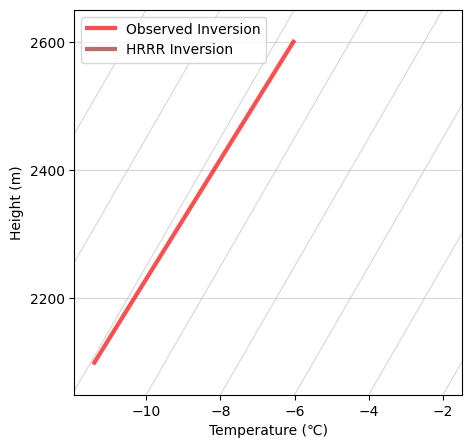

In [64]:
# Set up a date
date_of_interest = '2017-03-10 00:00'

# Grab the raw dataframes
OBS_df  = get_OBS_data(date_of_interest, 'RAP')
HRRR_df = mk_HRRR_df(date_of_interest)

# Convert to standard and normalized height coordinates
OBS_df_standard, HRRR_df_standard = mk_height_df(OBS_df, HRRR_df)
OBS_df_normalized, HRRR_df_normalized = mk_normalized_height_df(OBS_df_standard, HRRR_df_standard)

# get the primary inversions
OBS_prime, HRRR_prime = inversion_grabber(OBS_df_standard, OBS_df_normalized, HRRR_df_standard, HRRR_df_normalized)

# convert the primary inversions to a list which is needed for the plotter
OBS_prime_list  = []
HRRR_prime_list = []

if len(OBS_prime) != 0:
    OBS_prime_list = [[OBS_prime['Starting Height'].iloc[0], OBS_prime['Starting Temperature'].iloc[0]], [OBS_prime['Ending Height'].iloc[0], OBS_prime['Ending Temperature'].iloc[0]]]
    
if len(HRRR_prime) != 0:
    HRRR_prime_list = [[HRRR_prime['Starting Height'].iloc[0], HRRR_prime['Starting Temperature'].iloc[0]], [HRRR_prime['Ending Height'].iloc[0], HRRR_prime['Ending Temperature'].iloc[0]]]

# Plot the inversions
plotter(OBS_prime_list, HRRR_prime_list)

This date is bad too, because the HRRR just didn't make an inversion, so this is a False Negative


Grabbing OBS data for 2017-03-11 00:00

Grabbing HRRR HGT data for 2017-03-11 00:00
👨🏻‍🏭 Created directory: [C:\Users\perrl\data\hrrr\20170311]


D:\perrl\anaconda3\envs\Herb\lib\site-packages\herbie\archive.py:1010: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


Note: Returning a list of [10] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR TMP data for 2017-03-11 00:00


D:\perrl\anaconda3\envs\Herb\lib\site-packages\herbie\archive.py:1010: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR DPT data for 2017-03-11 00:00


D:\perrl\anaconda3\envs\Herb\lib\site-packages\herbie\archive.py:1010: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.

Grabbing HRRR OROG data for 2017-03-11 00:00
Note: Returning a list of [10] xarray.Datasets because cfgrib opened with multiple hypercubes.


C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\1666901665.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OBS_df_standard['lapse_rate'].iloc[i] = (OBS_df_standard['temperature'].iloc[i+1] - OBS_df_standard['temperature'].iloc[i]) / (OBS_df_standard['height'].iloc[i+1] - OBS_df_standard['height'].iloc[i])
C:\Users\perrl\AppData\Local\Temp\ipykernel_41540\1666901665.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRRR_df_standard['lapse_rate'].iloc[i] = (HRRR_df_standard['Temp (°C)'].iloc[i+1] - HRRR_df_standard['Temp (°C)'].iloc[i]) / (HRRR_df_standard['Height AGL (m)'].iloc[i+1] - HRRR_df_standard['Height 

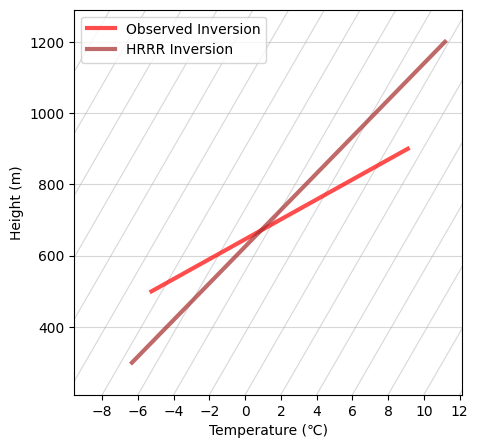

In [65]:
# Set up a date
date_of_interest = '2017-03-11 00:00'

# Grab the raw dataframes
OBS_df  = get_OBS_data(date_of_interest, 'RAP')
HRRR_df = mk_HRRR_df(date_of_interest)

# Convert to standard and normalized height coordinates
OBS_df_standard, HRRR_df_standard = mk_height_df(OBS_df, HRRR_df)
OBS_df_normalized, HRRR_df_normalized = mk_normalized_height_df(OBS_df_standard, HRRR_df_standard)

# get the primary inversions
OBS_prime, HRRR_prime = inversion_grabber(OBS_df_standard, OBS_df_normalized, HRRR_df_standard, HRRR_df_normalized)

# convert the primary inversions to a list which is needed for the plotter
OBS_prime_list  = []
HRRR_prime_list = []

if len(OBS_prime) != 0:
    OBS_prime_list = [[OBS_prime['Starting Height'].iloc[0], OBS_prime['Starting Temperature'].iloc[0]], [OBS_prime['Ending Height'].iloc[0], OBS_prime['Ending Temperature'].iloc[0]]]
    
if len(HRRR_prime) != 0:
    HRRR_prime_list = [[HRRR_prime['Starting Height'].iloc[0], HRRR_prime['Starting Temperature'].iloc[0]], [HRRR_prime['Ending Height'].iloc[0], HRRR_prime['Ending Temperature'].iloc[0]]]

# Plot the inversions
plotter(OBS_prime_list, HRRR_prime_list)

And this one looks good!

In the next notebook, we will run through 6 years of data at 4 different stations, detecting all the successful inversion detections, false positives, and false negatives in order to see the correctness of the HRRR